In [1]:
import os
import numpy as np
import random
from sklearn.model_selection import train_test_split

input_dir = "Data/rgb"
target_dir = "Data/segmentation_map"

#load input and segmented target image paths
input_image_path = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir)])
target_path = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir)])

In [2]:
#sanity check
assert len(input_image_path) == len(target_path)


In [3]:
def generate_target_ids(colors_to_rgb_txt = "Data/colors.txt"):
    """
    method to generate which maps:
        1. colors (str) to index(int) : range 0 to mum classes(15)
        2. index(int) to value([r(int), g(int), b(int)])
    """
    color_to_index_map = {}
    index_to_value_map = {}

    with open(colors_to_rgb_txt, "r") as f:
        lines = f.readlines()
        for id_, line in enumerate(lines[1:]):
            line = line.strip()
            line = line.split(" ")
            color, value = line[0], [int(x) for x in line[1:]]

            color_to_index_map[color] = id_
            index_to_value_map[id_] = value

    return color_to_index_map, index_to_value_map

color_to_index, index_to_value = generate_target_ids()
#get value (r,g,b) to index man
value_to_index = {tuple(v): k for k, v in index_to_value.items()}

In [4]:
def convert_target(target, value_to_index):
    """
    convert target segmentation map to [H, W, 1],
    where last channel is the index of the class.
    
    NOTE:
    We will later use sparse categorical cross entropy as loss
    
    """
    seg_map = np.zeros((target.shape[:2]), dtype="uint8")
    for val, id_ in value_to_index.items():
        seg_map[(target==list(val)).all(axis=2)] = id_
    return seg_map.reshape(target.shape[0], target.shape[1], 1)

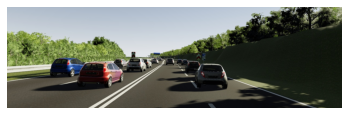

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_image_path[19]))

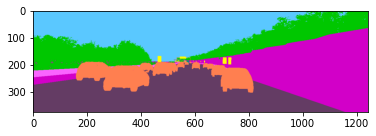

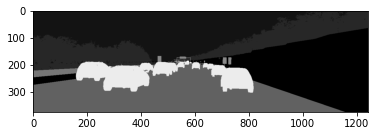

In [6]:
tr = img_to_array(load_img(target_path[19]))
plt.imshow(tr.astype("uint8"), cmap='gray')
plt.show()
seg = convert_target(tr.astype("uint8"), value_to_index)
plt.imshow(seg, cmap='gray')
plt.show()

# Data Preparation

In [7]:
img_size = (256,256)
num_images = len(input_image_path)

#shuffle
random.Random(12).shuffle(input_image_path)
random.Random(12).shuffle(target_path)

def get_img_from_path(path):
    return img_to_array(load_img(path, target_size=img_size))

def get_target_from_path(path):
    img = img_to_array(load_img(path, target_size=img_size,))
    img = convert_target(img.astype("uint8"), value_to_index)
    return img

input_images = np.zeros((num_images,) + img_size +(3,), dtype="float32")
targets = np.zeros((num_images,) + img_size +(1,), dtype="uint8")

for i in range(num_images):
    input_images[i] = get_img_from_path(input_image_path[i])/255.
    targets[i] = get_target_from_path(target_path[i])


In [8]:
#trai-test-validation split

train_inputs, test_inputs, train_targets, test_targets = train_test_split( input_images, targets ,test_size=0.20, random_state=42)
valid_inputs, test_inputs, valid_targets, test_targets = train_test_split(test_inputs, test_targets ,test_size=0.50, random_state=42)

In [10]:
#Data loaders for train and validation data

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 


train_dataloader = tf.data.Dataset.from_tensor_slices((train_inputs, train_targets))
valid_dataloader = tf.data.Dataset.from_tensor_slices((valid_inputs, valid_targets))
test_dataloader = tf.data.Dataset.from_tensor_slices((test_inputs, test_targets))

trainloader = (
    train_dataloader
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

validloader = (
    valid_dataloader
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [11]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
    plt.show()

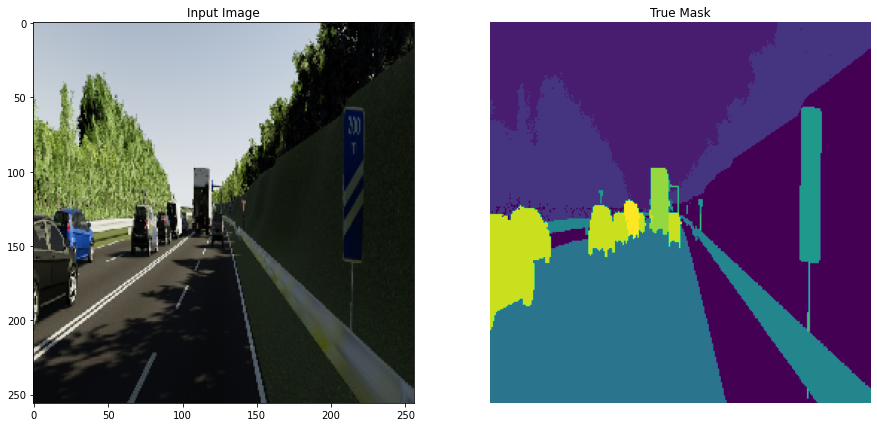

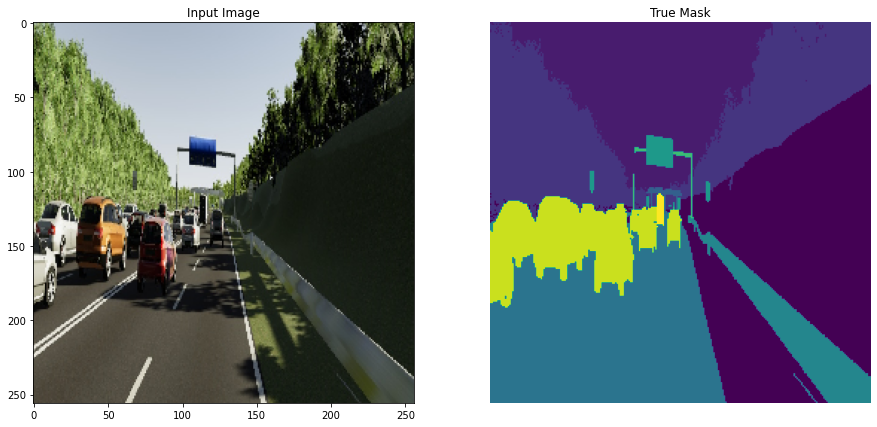

In [12]:
for images, masks in trainloader.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

# U-NET Model Creation

In [13]:
from tensorflow.keras import layers
from keras import backend as K
import keras
from tensorflow.keras.callbacks  import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [14]:
def get_UNET(img_size, num_classes=15):
    
    #encoder
    inputs = keras.Input(shape=img_size +(3,))
    
    conv1_1 = layers.Conv2D(16 ,3, padding="same")(inputs)
    bn1_1 = layers.BatchNormalization()(conv1_1)
    bn1_1 = layers.LeakyReLU()(bn1_1)
    conv1_2 = layers.Conv2D(16 ,3, padding="same")(bn1_1)
    bn1_2 = layers.BatchNormalization()(conv1_2)
    bn1_2 = layers.LeakyReLU()(bn1_2)
    max_pool_1 = layers.MaxPooling2D((2, 2))(bn1_2)
    resedual1 = layers.Conv2D(32,1,padding="same")(max_pool_1)
    
    conv2_1 = layers.Conv2D(32 ,3, padding="same")(max_pool_1)
    bn2_1 = layers.BatchNormalization()(conv2_1)
    bn2_1 = layers.LeakyReLU()(bn2_1)
    conv2_2 = layers.Conv2D(32 ,3, padding="same")(bn2_1)
    bn2_2 = layers.BatchNormalization()(conv2_2)
    bn2_2 = layers.add([bn2_2, resedual1])
    bn2_2 = layers.LeakyReLU()(bn2_2)
    max_pool_2 = layers.MaxPooling2D((2, 2))(bn2_2)
    resedual2 = layers.Conv2D(64,1,padding="same")(max_pool_2)
    
    conv3_1 = layers.Conv2D(64 ,3, padding="same")(max_pool_2)
    bn3_1 = layers.BatchNormalization()(conv3_1)
    bn3_1 = layers.LeakyReLU()(bn3_1)
    conv3_2 = layers.Conv2D(64 ,3, padding="same")(bn3_1)
    bn3_2 = layers.BatchNormalization()(conv3_2)
    bn3_2 = layers.add([bn3_2, resedual2])
    bn3_2 = layers.LeakyReLU()(bn3_2)
    max_pool_3 = layers.MaxPooling2D((2, 2))(bn3_2)
    resedual3 = layers.Conv2D(128,1,padding="same")(max_pool_3)
    
    
    conv4_1 = layers.Conv2D(128 ,3, padding="same")(max_pool_3)
    bn4_1 = layers.BatchNormalization()(conv4_1)
    bn4_1 = layers.LeakyReLU()(bn4_1)
    conv4_2 = layers.Conv2D(128 ,3, padding="same")(bn4_1)
    bn4_2 = layers.BatchNormalization()(conv4_2)
    bn4_2 = layers.add([bn4_2, resedual3])
    bn4_2 = layers.LeakyReLU()(bn4_2)
    conv4_3 = layers.Conv2D(128 ,3, padding="same")(bn4_2)
    bn4_3 = layers.BatchNormalization()(conv4_3)
    bn4_3 = layers.LeakyReLU()(bn4_3)
    
    conv5_1 = layers.Conv2D(64 ,3, padding="same")(bn4_3)
    bn5_1 = layers.BatchNormalization()(conv5_1)
    bn5_1 = layers.LeakyReLU()(bn5_1)
    conv5_2 = layers.Conv2D(64 ,3, padding="same")(bn5_1)
    bn5_2 = layers.BatchNormalization()(conv5_2)
    bn5_2 = layers.LeakyReLU()(bn5_2)
    conv5_3 = layers.Conv2D(64 ,3, padding="same")(bn5_2)
    bn5_3 = layers.BatchNormalization()(conv5_3)
    bn5_3 = layers.LeakyReLU()(bn5_3)
    resedual5 = layers.Conv2DTranspose(32, 2, strides=(2,2), padding="same")(bn5_3)
    resedual5 = layers.Conv2D(32, 1, padding="same")(resedual5)
    
    #decoder
    
    conv6_up = layers.Conv2DTranspose(32, 3, strides = (2, 2), padding = 'same')(bn5_3)
    conv6_up = layers.BatchNormalization()(conv6_up)
    conv6_up = layers.add([conv6_up, resedual5])
    conv6_up = layers.concatenate([conv6_up, bn3_2])
    conv6_up = layers.LeakyReLU()(conv6_up)
    conv6_1 = layers.Conv2D(32 ,3, padding="same")(conv6_up)
    bn6_1 = layers.BatchNormalization()(conv6_1)
    bn6_1 = layers.LeakyReLU()(bn6_1)
    conv6_2 = layers.Conv2D(32 ,3, padding="same")(bn6_1)
    bn6_2 = layers.BatchNormalization()(conv6_2)
    bn6_2 = layers.LeakyReLU()(bn6_2)
    resedual6 = layers.Conv2DTranspose(16, 2, strides=(2,2), padding="same")(bn6_2)
    resedual6 = layers.Conv2D(16, 1, padding="same")(resedual6)
    
    
    conv7_up = layers.Conv2DTranspose(16, 3, strides = (2, 2), padding = 'same')(bn6_2)
    conv7_up = layers.BatchNormalization()(conv7_up)
    conv7_up = layers.add([conv7_up, resedual6])
    conv7_up = layers.concatenate([conv7_up, bn2_2])
    conv7_up = layers.LeakyReLU()(conv7_up)
    conv7_1 = layers.Conv2D(16 ,3, padding="same")(conv7_up)
    bn7_1 = layers.BatchNormalization()(conv7_1)
    bn7_1 = layers.LeakyReLU()(bn7_1)
    conv7_2 = layers.Conv2D(16 ,3, padding="same")(bn7_1)
    bn7_2 = layers.BatchNormalization()(conv7_2)
    bn7_2 = layers.LeakyReLU()(bn7_2)
    resedual7 = layers.Conv2DTranspose(num_classes, 2, strides=(2,2), padding="same")(bn7_2)
    resedual7 = layers.Conv2D(num_classes, 1, padding="same")(resedual7)
    
    
    conv8_up = layers.Conv2DTranspose(num_classes, 3, strides = (2, 2), padding = 'same')(bn7_2)
    conv8_up = layers.BatchNormalization()(conv8_up)
    conv8_up = layers.add([conv8_up, resedual7])
    conv8_up = layers.concatenate([conv8_up, bn1_2])
    conv8_up = layers.LeakyReLU()(conv8_up)
    conv8_1 = layers.Conv2D(num_classes ,3, padding="same")(conv8_up)
    bn8_1 = layers.BatchNormalization()(conv8_1)
    bn8_1 = layers.LeakyReLU()(bn8_1)
    conv8_2 = layers.Conv2D(num_classes ,3, padding="same")(bn8_1)
    bn8_2 = layers.BatchNormalization()(conv8_2)
    bn8_2 = layers.LeakyReLU()(bn8_2) 
    
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(bn8_2)
    model = keras.Model(inputs, outputs)
    return model

In [15]:
model = get_UNET(img_size, num_classes=15)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_7 (BatchNo  (None, 32, 32, 128)  512        ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 conv2d_8 (Conv2D)              (None, 32, 32, 128)  8320        ['max_pooling2d_2[0][0]']        
                                                                                                  
 add_2 (Add)                    (None, 32, 32, 128)  0           ['batch_normalization_7[0][0]',  
                                                                  'conv2d_8[0][0]']               
                                                                                                  
 leaky_re_lu_7 (LeakyReLU)      (None, 32, 32, 128)  0           ['add_2[0][0]']                  
                                                                                                  
 conv2d_11

 add_4 (Add)                    (None, 128, 128, 16  0           ['batch_normalization_15[0][0]', 
                                )                                 'conv2d_18[0][0]']              
                                                                                                  
 concatenate_1 (Concatenate)    (None, 128, 128, 48  0           ['add_4[0][0]',                  
                                )                                 'leaky_re_lu_3[0][0]']          
                                                                                                  
 leaky_re_lu_15 (LeakyReLU)     (None, 128, 128, 48  0           ['concatenate_1[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  6928        ['leaky_re_lu_15[0][0]']         
          

In [47]:
def CE_dice_loss(y_true, y_pred, lamb1 = 0.2, lamb2= 0.8, gamma=1e-6):
    
    CE =  tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    
    
    y_true_dice = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=15))
    y_pred_dice = K.flatten(y_pred)
    
    intersect = K.sum(y_true_dice * y_pred_dice, axis=-1)
    denom = K.sum(y_true_dice * y_true_dice, axis=-1) + K.sum(y_pred_dice * y_pred_dice, axis=-1)
    
    dice_loss = 1- K.mean((2. * intersect + gamma) / (denom + gamma)) 
    
    return lamb1*CE + lamb2*(dice_loss)
    


In [54]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('seg_weights.h5', verbose=1, save_best_only=True)
]

# Model Training

In [50]:
model.compile(optimizer='rmsprop', loss=CE_dice_loss)
history = model.fit(trainloader, epochs=100, validation_data=validloader, callbacks=callbacks)

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.0605
Epoch 1: val_loss improved from inf to 0.02979, saving model to weights.h5
42/42 [==============================] - 13s 212ms/step - loss: 0.0605 - val_loss: 0.0298 - lr: 0.0010
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.0598
Epoch 2: val_loss did not improve from 0.02979
42/42 [==============================] - 8s 199ms/step - loss: 0.0598 - val_loss: 0.0376 - lr: 0.0010
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.0446
Epoch 3: val_loss did not improve from 0.02979
42/42 [==============================] - 8s 200ms/step - loss: 0.0446 - val_loss: 0.1104 - lr: 0.0010
Epoch 4/100
42/42 [==============================] - ETA: 0s - loss: 0.0273
Epoch 4: val_loss did not improve from 0.02979
42/42 [==============================] - 8s 201ms/step - loss: 0.0273 - val_loss: 0.0346 - lr: 0.0010
Epoch 5/100
42/42 [==============================] - ETA: 0s - loss: 0.

42/42 [==============================] - 8s 201ms/step - loss: 0.0213 - val_loss: 0.0242 - lr: 1.0000e-05
Epoch 34/100
42/42 [==============================] - ETA: 0s - loss: 0.0213
Epoch 34: val_loss did not improve from 0.02412
42/42 [==============================] - 8s 202ms/step - loss: 0.0213 - val_loss: 0.0241 - lr: 1.0000e-05
Epoch 35/100
42/42 [==============================] - ETA: 0s - loss: 0.0214
Epoch 35: val_loss did not improve from 0.02412
42/42 [==============================] - 8s 201ms/step - loss: 0.0214 - val_loss: 0.0241 - lr: 1.0000e-05
Epoch 36/100
42/42 [==============================] - ETA: 0s - loss: 0.0214
Epoch 36: val_loss improved from 0.02412 to 0.02411, saving model to weights.h5
42/42 [==============================] - 9s 207ms/step - loss: 0.0214 - val_loss: 0.0241 - lr: 1.0000e-05
Epoch 37/100
42/42 [==============================] - ETA: 0s - loss: 0.0213
Epoch 37: val_loss improved from 0.02411 to 0.02409, saving model to weights.h5
42/42 [=====

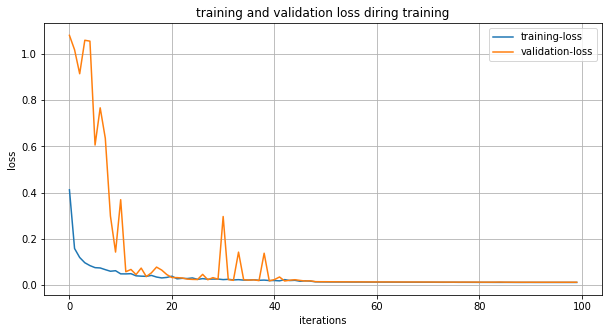

In [23]:
plt.figure(figsize=(10, 5))
training_history = history.history

plt.plot(range(len(training_history["loss"])), training_history["loss"], label="training-loss")
plt.plot(range(len(training_history["loss"])), training_history["val_loss"], label="validation-loss")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.title("training and validation loss diring training")
plt.show()

# Prediction and evaluation on Test Data

In [55]:
loaded_model = keras.models.load_model("seg_weights.h5", custom_objects={"CE_dice_loss":CE_dice_loss})
preds = np.argmax(loaded_model.predict(test_inputs), axis=-1)

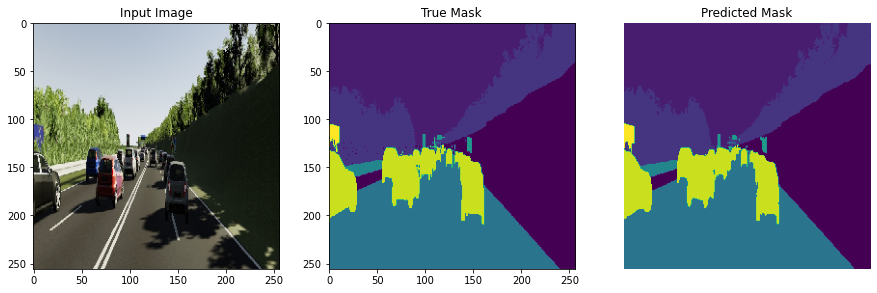

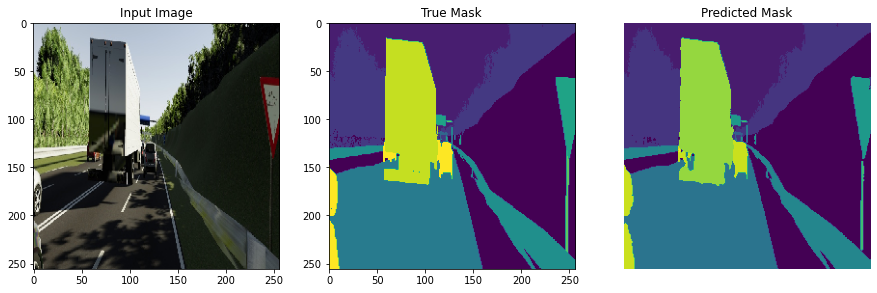

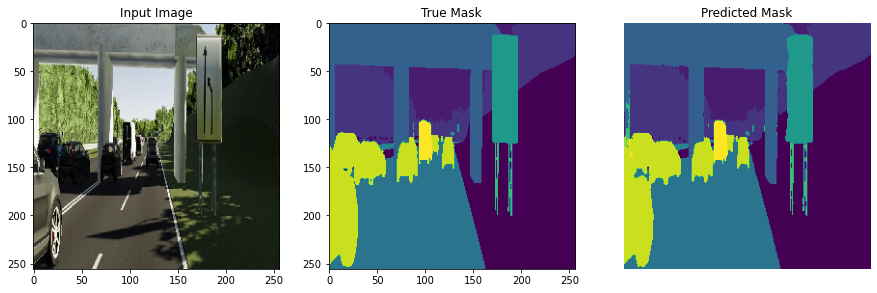

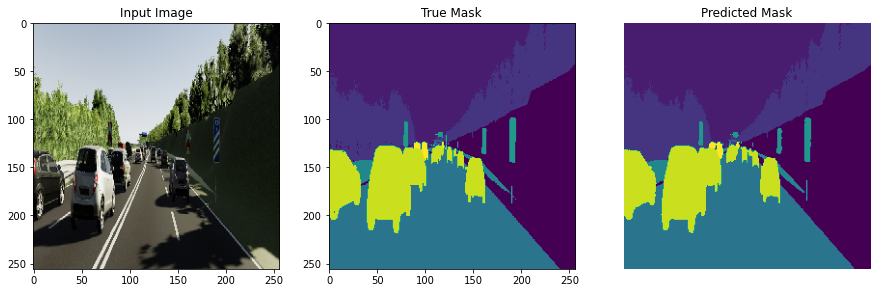

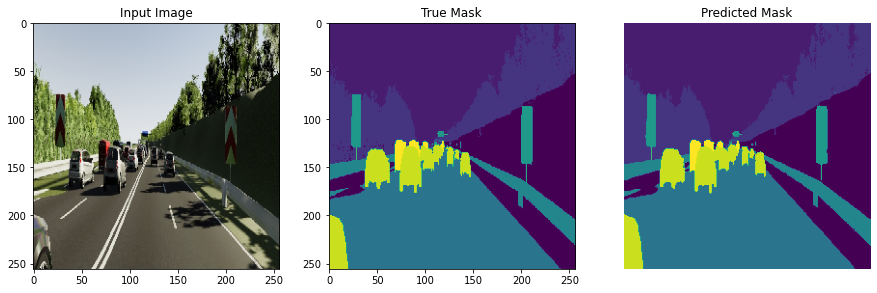

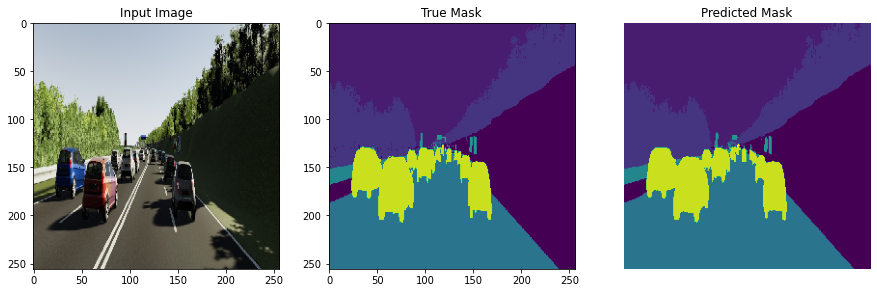

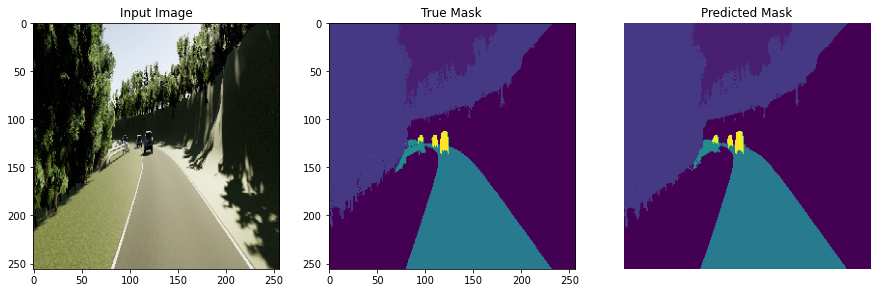

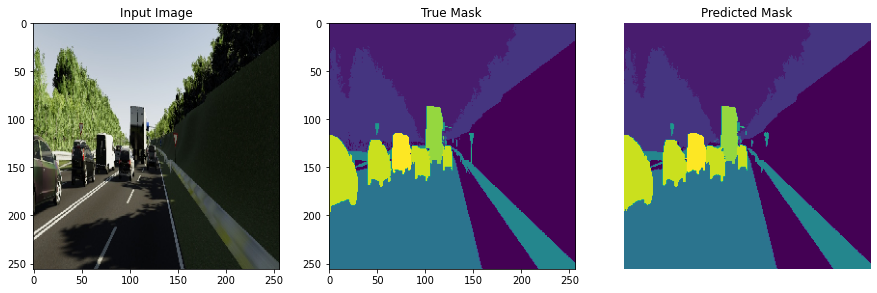

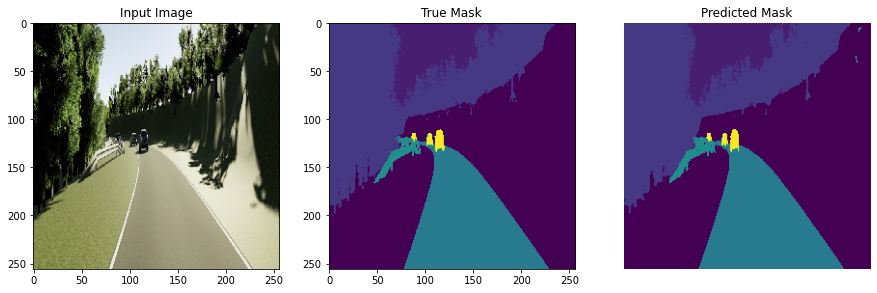

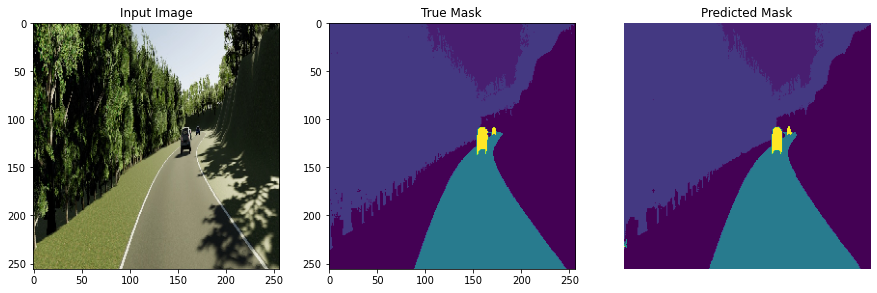

In [41]:
#qualitative results
for i in range(50,60):
    display([test_inputs[i], test_targets[i], preds[i].reshape((256, 256, 1))])

In [56]:
def IoU_metric(y_true, y_pred):
    num_classes = y_pred.shape[-1]
    y_true = y_true.reshape((y_true.shape[0], y_true.shape[1], y_true.shape[2]))
    y_pred = np.array([ np.argmax(y_pred, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0)
    y_true = np.array([ y_true == i for i in range(num_classes) ]).transpose(1,2,3,0)

    intersection = np.sum(np.logical_and(y_pred, y_true), axis=(1, 2))
    union = np.sum(np.logical_or(y_pred, y_true), axis=(1, 2))

    smooth = 1e-4
    iou = (intersection + smooth) / (union + smooth)
    return np.mean(iou)

def Dice_coeff(y_true, y_pred):
    num_classes = y_pred.shape[-1]
    y_true = y_true.reshape((y_true.shape[0], y_true.shape[1], y_true.shape[2]))
    y_pred = np.array([ np.argmax(y_pred, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0).astype("uint8")
    y_true = np.array([ y_true == i for i in range(num_classes) ]).transpose(1,2,3,0).astype("uint8")
    
    smooth = 1e-4
    numerator = np.sum(np.abs(y_pred * y_true), axis=(1, 2))
    denominator = np.sum(np.abs(y_true), axis=(1, 2)) + np.sum(np.abs(y_pred), axis=(1, 2))
    dice = (2 * (numerator) + smooth)/(denominator + smooth)
    
    return np.mean(dice)
    

In [57]:
sfmax_predictions = loaded_model.predict(test_inputs)


In [58]:
mean_iou = IoU_metric(test_targets, sfmax_predictions)
mean_dice = Dice_coeff(test_targets, sfmax_predictions)

print(mean_iou, mean_dice)

0.8737027487368464 0.9005870290706641
